Importing required packages for EDA and model creation

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import base64
import io
from scipy.misc import imread
import codecs
import pickle

# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from IPython.display import display
from IPython.display import HTML
from matplotlib_venn import venn2

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

reading excel data to pandas dataframe

In [4]:
df = pd.read_excel("input/Toy_Dataset.xlsx", sheetname="Toy_Dataset")
df.head()

,index,user_id,gender,age,start_bmi,activity_factor,OS,connected_pedometer,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,devicebrand,paid
0,109000,2224406.0,male,44.0,32.7,1.725,ios,NaN,0,0,0,0,0,0,0,0,apple,0
1,109001,2224394.0,female,63.0,33.7,1.200,android,NaN,0,0,0,0,0,0,0,0,motorola,0
2,109002,2224399.0,male,141.0,31.4,1.550,android,NaN,0,0,0,0,1,0,0,1,samsung,0
3,109003,2224448.0,male,107.0,34.9,1.200,android,google_fit,0,0,0,0,0,0,0,0,vivo,0
4,109004,2224393.0,female,98.0,37.8,1.375,android,NaN,1,0,0,0,0,0,0,1,samsung,0


# Checking for null values

In [5]:
df.isnull().sum()

index                      0
user_id                 9000
gender                     2
age                     9002
start_bmi              10471
activity_factor            7
OS                         0
connected_pedometer    79513
hypothyroid                0
diabetes                   0
pcos                       0
physical                   0
hypertension               0
high_blood_pressure        0
cholesterol                0
medical_conditions         0
devicebrand                0
paid                       0
dtype: int64

Droping irrelevent features (index, user_id). Dropping 'connected_pedometer' as more than half of it's value is null.

In [6]:
updated_df = df.drop(['index', 'user_id', 'connected_pedometer'], axis = 1)
print("Updated dataset have {} rows and {} features".format(updated_df.shape[0], updated_df.shape[1]))

Updated dataset have 100865 rows and 15 features


In [7]:
updated_df.describe()

,age,start_bmi,activity_factor,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,paid
count,91863.000000,90394.000000,100858.000000,100865.000000,100865.000000,100865.000000,100865.000000,100865.000000,100865.000000,100865.000000,100865.000000,100865.000000
mean,83.169263,33.524202,1.374217,0.102295,0.057532,0.058167,0.034422,0.084816,0.000902,0.083260,0.345987,0.010321
std,30.235619,4.969434,0.172002,0.303038,0.232858,0.234060,0.182312,0.278610,0.030023,0.276276,0.475691,0.101066
min,14.000000,7.400000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,30.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,83.000000,33.100000,1.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,108.000000,36.300000,1.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,186.000000,99.800000,1.725000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Age distribution is little weird as the max age of a person is 186. The most oldest person was around 123 years old. So, Getting the data for those are less than 125 years old. (Topic of discussion)

In [8]:
updated_df = updated_df[updated_df.age < 125]
updated_df.age.max()

124.0

# Understanding user's OS distribution

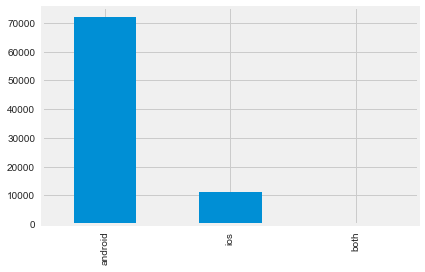

In [9]:
updated_df['OS'].value_counts().plot.bar()
plt.show()

# Checking how many people have paid subscriptions?

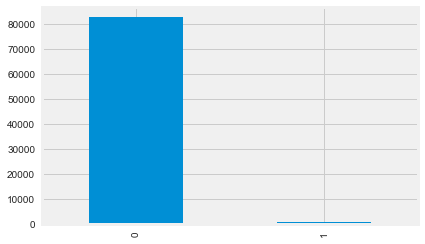

In [10]:
updated_df['paid'].value_counts().plot.bar()
plt.show()

As per this distribution, Very less people have paid subscription. Let's go to more details.

# How many having medical conditions?

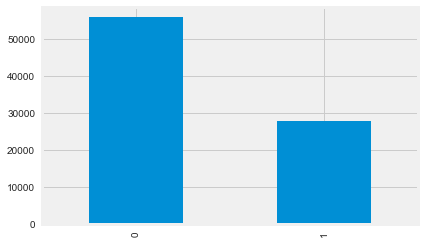

In [11]:
updated_df['medical_conditions'].value_counts().plot.bar()
plt.show()

Near of 1/3rd users having medical condition. SO, medical condition is a crucial feature that drives uses to join our platform. Any enhancement in medical section of our product can increase our userbase.

# Let's understand our user's age

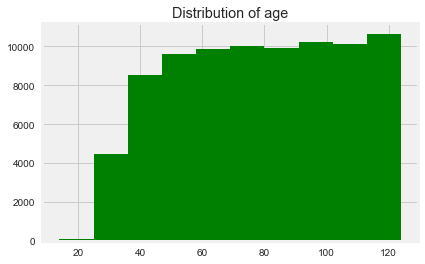

In [12]:
plt.hist(updated_df['age'], facecolor='g')
plt.title('Distribution of age')
plt.grid(True)
plt.show()

Most of our user having more than 40 years of age. So, our product should focus more on this segment of users as they covers more than 2/3rd of our userbase. As largest population of this country, people's having age ranging from 15-65. Focusing on this segment can give us much bigger userbase with more paid subscriptions.

# Understanding paid users

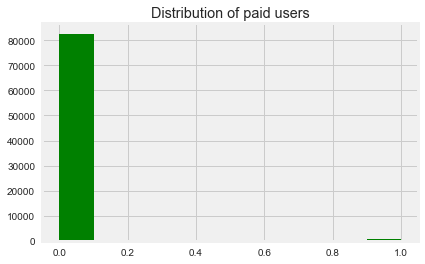

In [13]:
plt.hist(updated_df['paid'], facecolor='g')
plt.title('Distribution of paid users')
plt.grid(True)
plt.show()

# Users top 15 device brand

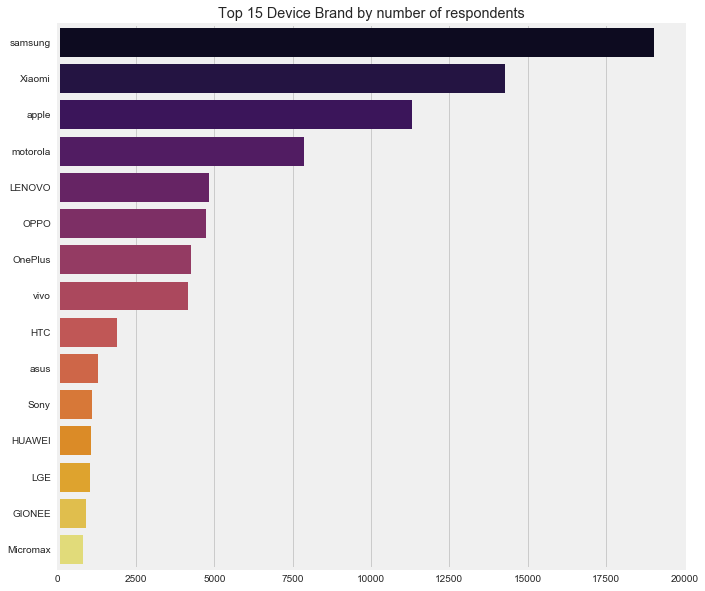

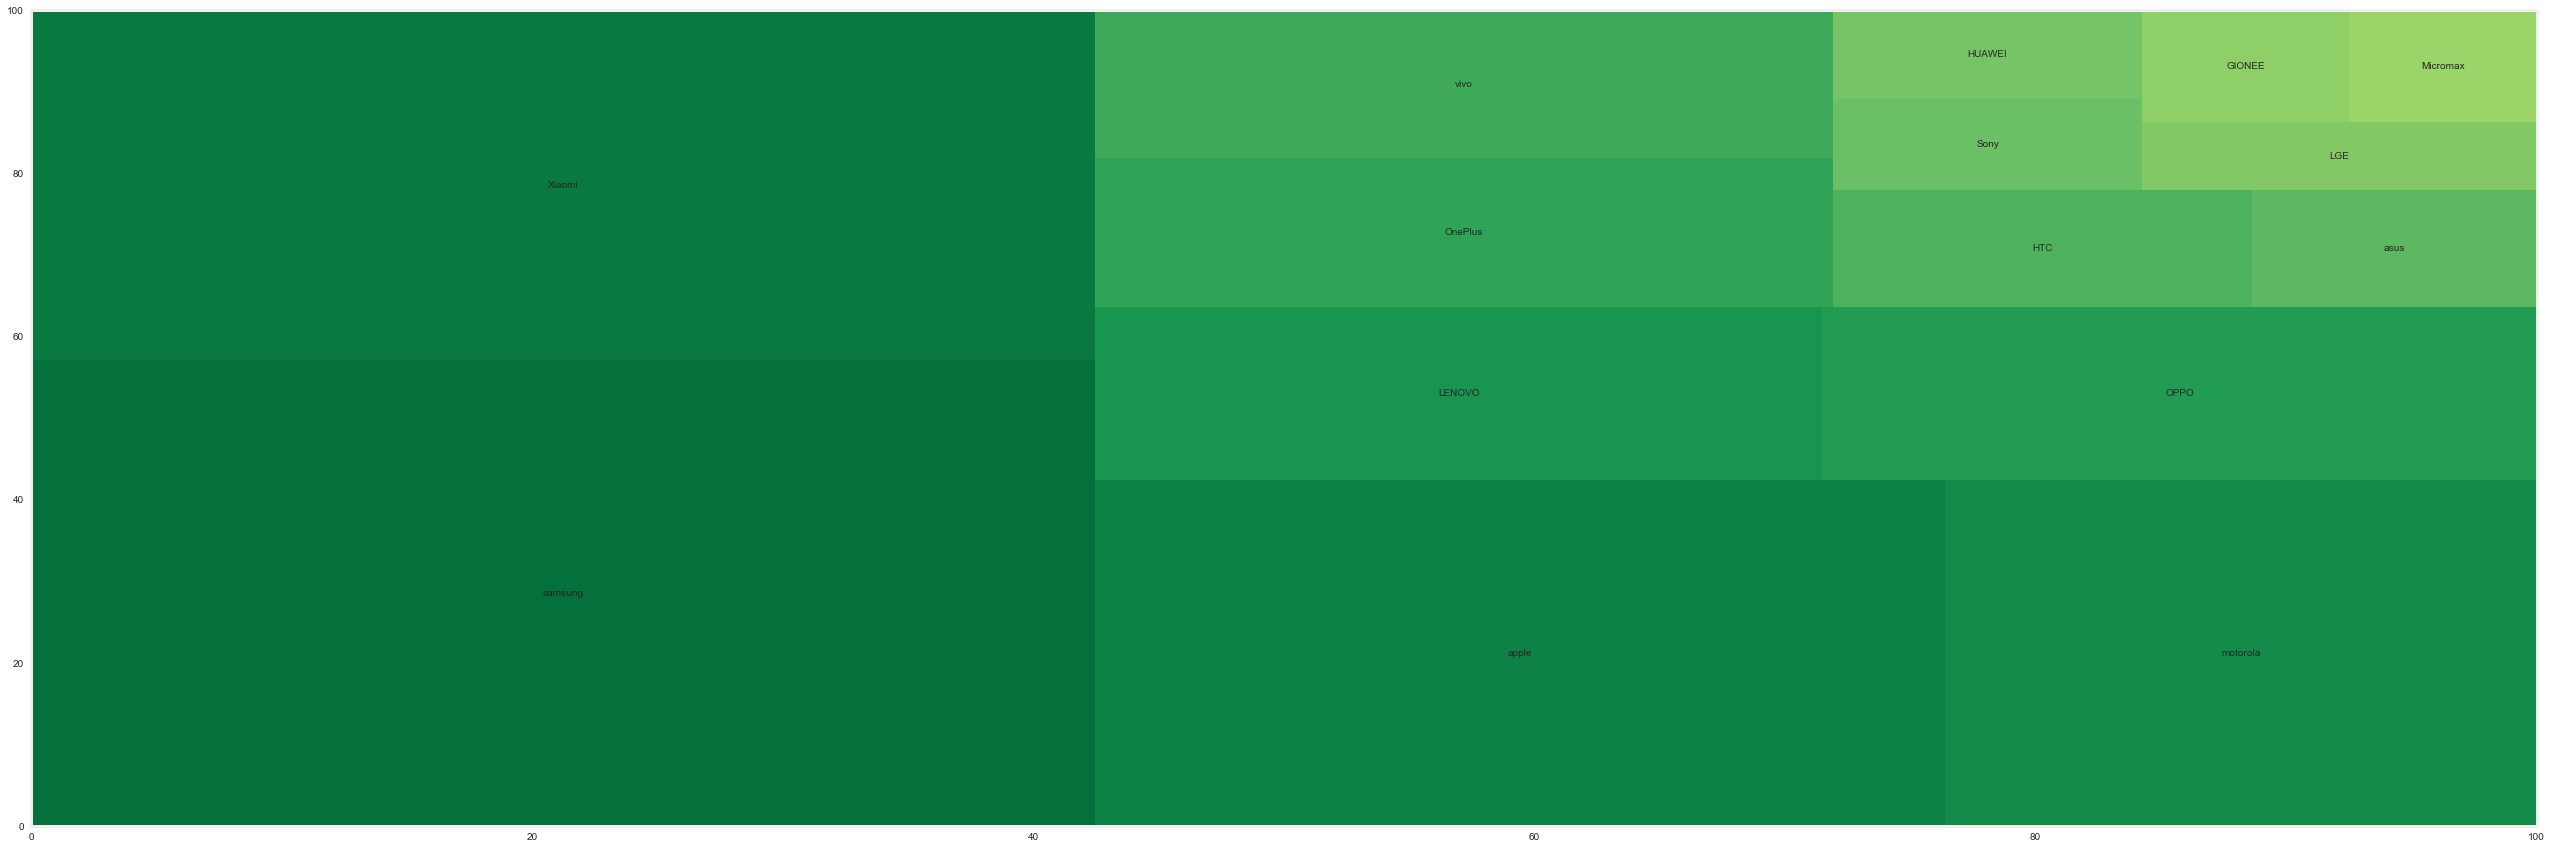

In [14]:
resp_coun = updated_df['devicebrand'].value_counts()[:15].to_frame()
sns.barplot(resp_coun['devicebrand'],resp_coun.index,palette='inferno')
plt.title('Top 15 Device Brand by number of respondents')
plt.xlabel('')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()
tree=updated_df['devicebrand'].value_counts()[:15].to_frame()
squarify.plot(sizes=tree['devicebrand'].values,label=tree.index,color=sns.color_palette('RdYlGn_r',52))
plt.rcParams.update({'font.size':20})
fig=plt.gcf()
fig.set_size_inches(40,15)
plt.show()

#  BMI Distribution

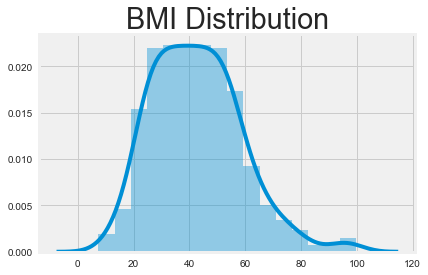

In [15]:
start_bmi=updated_df['start_bmi'].dropna().unique()
sns.distplot(start_bmi)
plt.title('BMI Distribution')
plt.show()

# Relation in age and gender

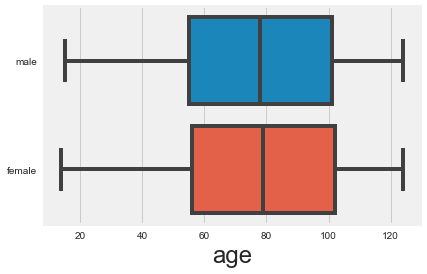

In [16]:
sns.boxplot(y='gender',x='age',data=updated_df)
plt.ylabel('')
plt.show()

# User's Age Distribution

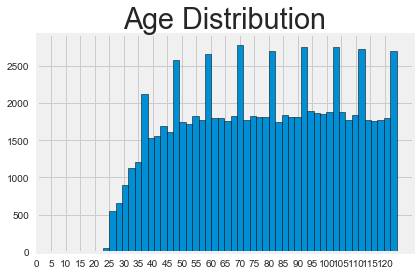

In [17]:
updated_df['age'].hist(bins=50,edgecolor='black')
plt.xticks(list(range(0,125,5)))
plt.title('Age Distribution')
plt.show() 

# How Start_BMI behave with activity factor?

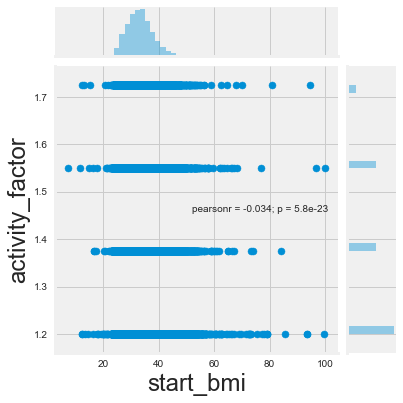

In [18]:
sns.jointplot(x="start_bmi", y="activity_factor", data=updated_df)
plt.show()

#  Let's create a dataframe with medical records only

In [19]:
med_df = updated_df[['hypothyroid','diabetes', 'pcos', 'physical', 'hypertension', 'high_blood_pressure', 'cholesterol', 'medical_conditions', 'paid']]
med_df.head()

,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,paid
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0


# Histograms to understand medical features

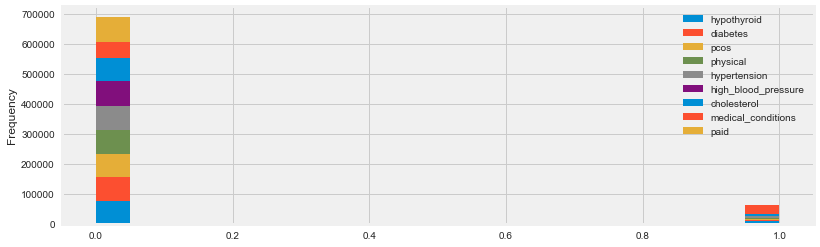

In [123]:
med_df.plot.hist(stacked=True, bins=20)

Medical data is skewed alot along with paid subscription features. 'medical_condition' feature is little good as it's data distribution is slightly even. 

# FInd correlation between them

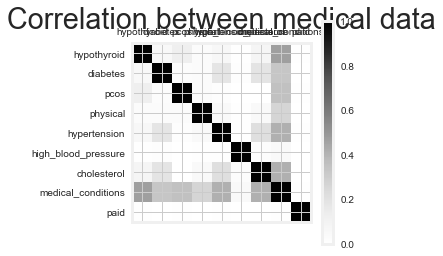

In [21]:
plt.matshow(med_df.corr())
plt.title("Correlation between medical data")
plt.xticks(range(len(med_df.columns)), med_df.columns)
plt.yticks(range(len(med_df.columns)), med_df.columns)
plt.colorbar()
plt.show()

'Hypothyroid' feature is more correlated with 'medical_conditions' than other features. So, having Hypothyroid will cause having medical problems in more cases. Below is the bar plot to show this.

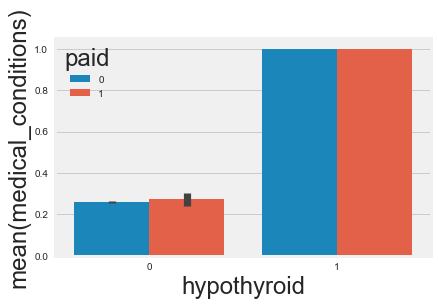

In [22]:
sns.barplot(x="hypothyroid", y="medical_conditions", hue="paid", data=updated_df)
plt.show()

# Check medical conditions by age

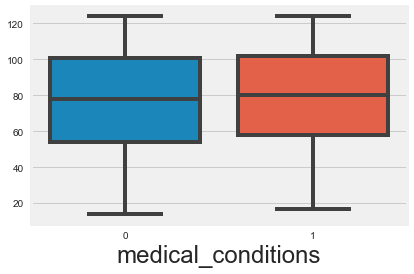

In [23]:
sns.boxplot(y='age',x='medical_conditions',data=updated_df)
plt.ylabel('')
plt.show()

So, medical_condition is distributed even for age in the given region.

# Understand user's OS on our platform

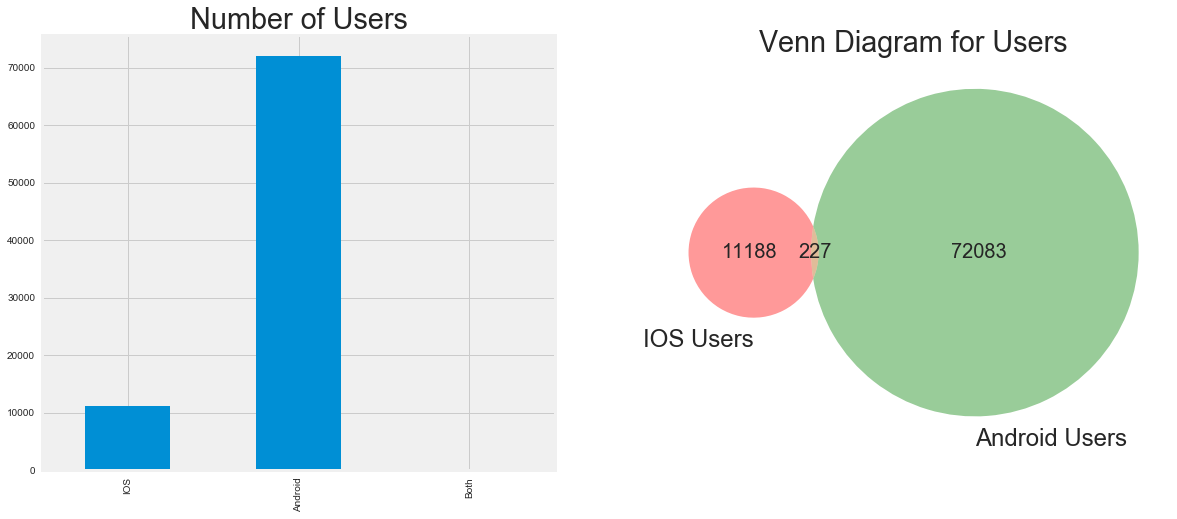

In [24]:
num_ios = updated_df.OS[updated_df.OS == 'ios'].count()
num_andriod = updated_df.OS[updated_df.OS == 'android'].count()
num_both = updated_df.OS[updated_df.OS == 'both'].count()

f,ax=plt.subplots(1,2,figsize=(18,8))
pd.Series([num_ios, num_andriod,num_both],index=['IOS','Android','Both']).plot.bar(ax=ax[0])
ax[0].set_title('Number of Users')
venn2(subsets = (num_ios,num_andriod,num_both), set_labels = ('IOS Users', 'Android Users'))
plt.title('Venn Diagram for Users')
plt.show()

Android users are dominating on this product too. Focusing more on enhancing product for IOS users can help increase our userbase.

# Let's get deeper insights on user's distribution on every categorical features

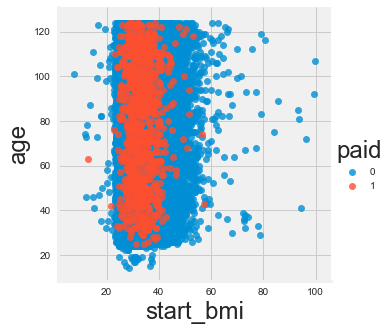

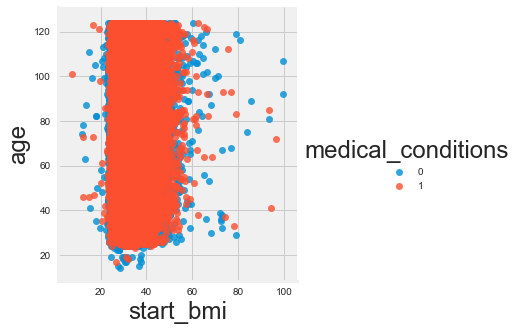

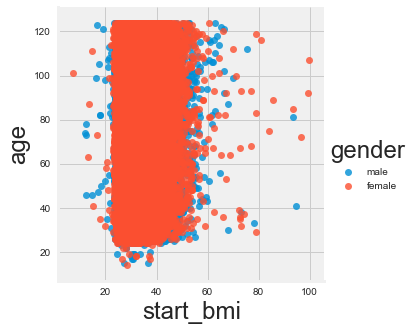

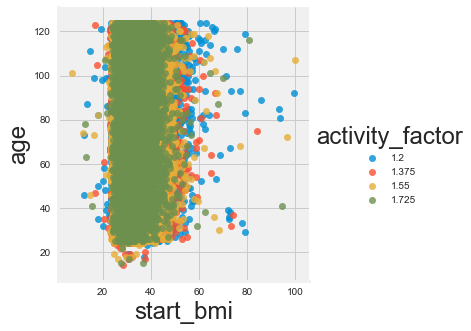

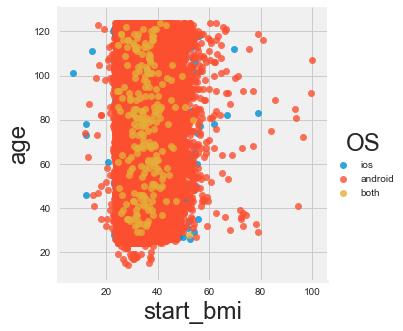

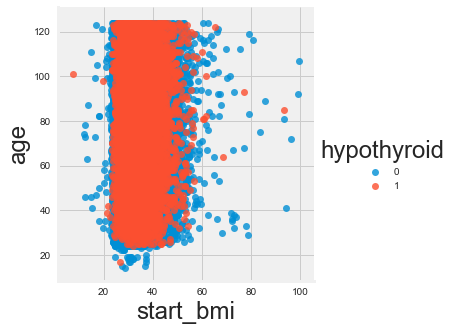

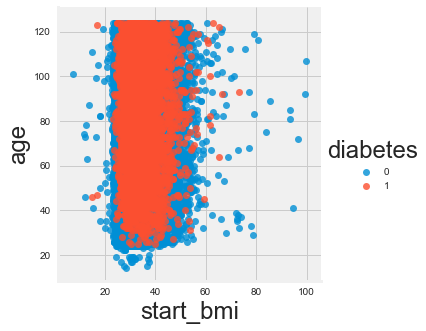

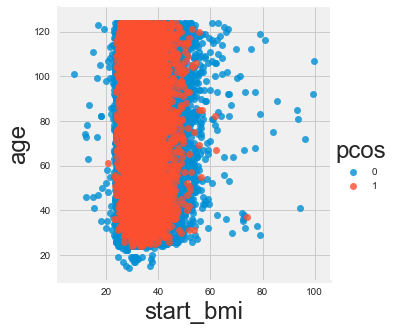

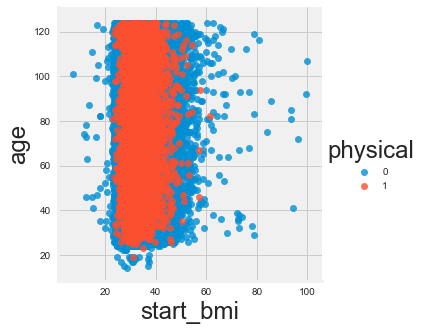

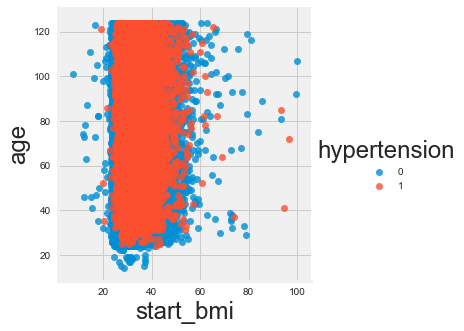

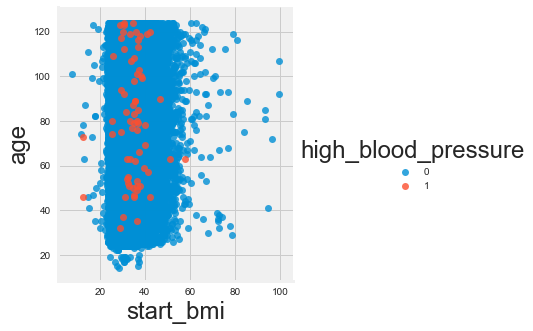

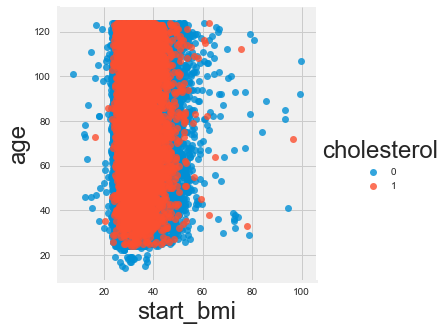

In [25]:
features = ['paid', 'medical_conditions', 'gender', 'activity_factor', 'OS', 'hypothyroid','diabetes', 'pcos', 'physical', 'hypertension', 'high_blood_pressure', 'cholesterol']
for each in features:
    sns.lmplot( x="start_bmi", y="age", data=updated_df, fit_reg=False, hue=each, legend=True)
    sns.plt.show()

# Effect of all other features on paid and age features

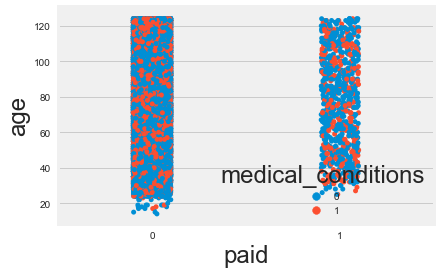

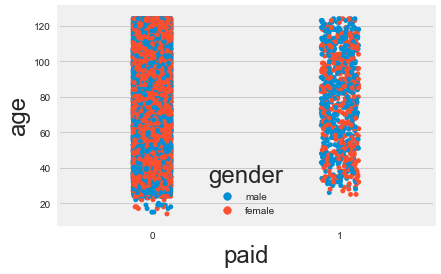

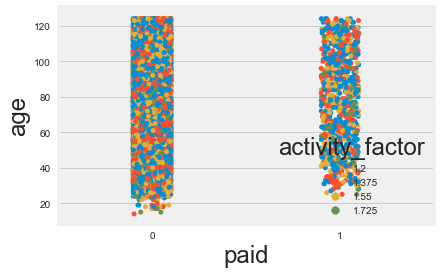

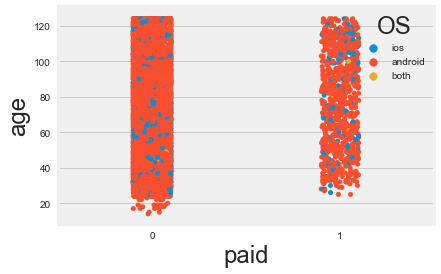

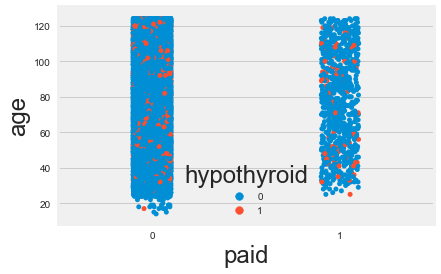

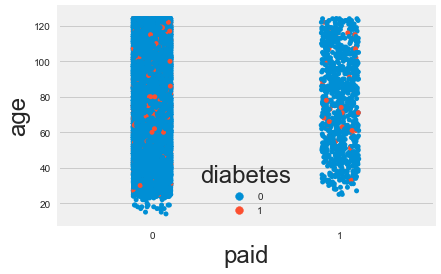

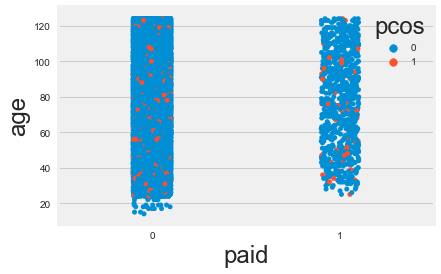

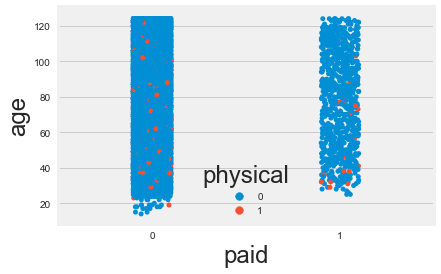

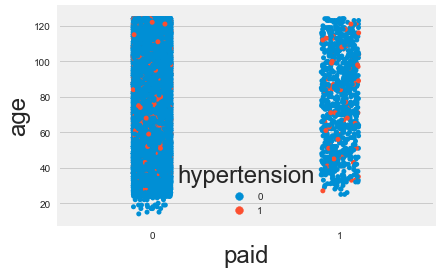

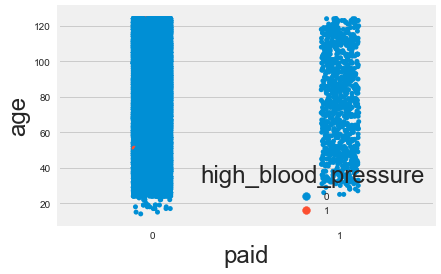

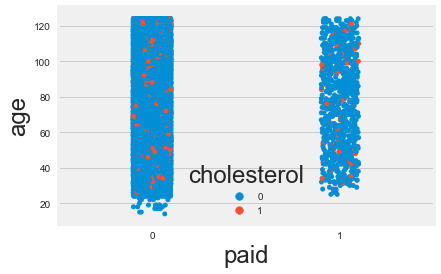

In [26]:
par_features = ['medical_conditions', 'gender', 'activity_factor', 'OS', 'hypothyroid','diabetes', 'pcos', 'physical', 'hypertension', 'high_blood_pressure', 'cholesterol']
for each in par_features:
    sns.stripplot(x="paid", y="age", hue = each, data=updated_df, jitter=True)
    plt.show()

#  Let's preprocess the dataset and create a model to predict if user is going to take Premium plan (Data is very imbalance -> 1: 100)

In [27]:
updated_df.head()

,gender,age,start_bmi,activity_factor,OS,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,devicebrand,paid
0,male,44.0,32.7,1.725,ios,0,0,0,0,0,0,0,0,apple,0
1,female,63.0,33.7,1.200,android,0,0,0,0,0,0,0,0,motorola,0
3,male,107.0,34.9,1.200,android,0,0,0,0,0,0,0,0,vivo,0
4,female,98.0,37.8,1.375,android,1,0,0,0,0,0,0,1,samsung,0
5,male,85.0,28.6,1.550,android,0,0,0,0,0,0,0,0,LENOVO,0


# Target data is highly skewed.  Try SMOTE(Oversampling) and weight_balance 

In [28]:
updated_df['paid'].value_counts()

0    82617
1      881
Name: paid, dtype: int64

target feature is skewed a lot.

Dropping NA values as it is not adding more skewness.

In [29]:
cleaned_df = updated_df.dropna()
cleaned_df.isnull().sum()

gender                 0
age                    0
start_bmi              0
activity_factor        0
OS                     0
hypothyroid            0
diabetes               0
pcos                   0
physical               0
hypertension           0
high_blood_pressure    0
cholesterol            0
medical_conditions     0
devicebrand            0
paid                   0
dtype: int64

In [30]:
cleaned_df['paid'].value_counts()

0    81282
1      874
Name: paid, dtype: int64

# Now Encode categorical value

In [31]:
def update_brand(value):
    if value == "samsung":
        return 1
    elif value == "Xiaomi":
        return 2
    elif value == "apple":
        return 3
    else:
        return 4

In [32]:
cleaned_df["devicebrand"] = cleaned_df["devicebrand"].apply(lambda x: update_brand(x))
cols_to_transform = [ 'gender', 'OS']
df_with_dummies = pd.get_dummies(cleaned_df, columns = cols_to_transform )
df_with_dummies.head()

,age,start_bmi,activity_factor,hypothyroid,diabetes,pcos,physical,hypertension,high_blood_pressure,cholesterol,medical_conditions,devicebrand,paid,gender_female,gender_male,OS_android,OS_both,OS_ios
0,44.0,32.7,1.725,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1
1,63.0,33.7,1.200,0,0,0,0,0,0,0,0,4,0,1,0,1,0,0
3,107.0,34.9,1.200,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0
4,98.0,37.8,1.375,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0
5,85.0,28.6,1.550,0,0,0,0,0,0,0,0,4,0,0,1,1,0,0


# Split the data into target and features

In [33]:
# Split the data into features and target label
paid_raw = df_with_dummies['paid']
features_raw = df_with_dummies.drop('paid', axis = 1)

In [34]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(paid_raw)))

Original dataset shape Counter({0: 81282, 1: 874})


# Try SMOTE to oversample the data 

In [57]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
smote_features, smote_paid = sm.fit_sample(features_raw, paid_raw)

In [58]:
print('After SMOTE dataset shape {}'.format(Counter(smote_paid)))

After SMOTE dataset shape Counter({0: 81282, 1: 81282})


After applying Smote, data is balanced equally

# Scaling the numerical features to ensure our model treats every feature equally.

In [76]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
scaled_smote_features = scaler.fit_transform(smote_features)

# Applying Principal componant analysis to reduce dimension of data

In [69]:
# Reduce data dimension
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca_features = pca.fit_transform(scaled_smote_features)

# Splitting the data into train and test set

In [77]:
X_train, X_test, y_train, y_test = train_test_split(scaled_smote_features, smote_paid, test_size=0.25, random_state=40)

Plot confusion matrix for each prediction as data was highly unbalanced.

In [88]:
def plot_confusion_matrix(clf, y_test, predicted_labels, sample_size):
    cm = confusion_matrix(y_test, predicted_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', square=True, fmt='.4f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for\n{} on {} samples.'.format(clf.__class__.__name__, sample_size))
    plt.show()

Training model on 1%, 10% and 100% of the training data and predicting the results.

In [89]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

beta = 0.5

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,  beta = beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = beta)
    
    plot_confusion_matrix(learner, y_test, predictions_test, sample_size)
    
    # print("Confusion matrix for {} on {} samples: {}".format(learner.__class__.__name__, sample_size, confusion_matrix(y_test, predictions_test)))
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

# Training the models using three different ML algorithms.

Trying Boosting algorithms as it penelize the incorrect predictions and gives more weight to that sample.

121923


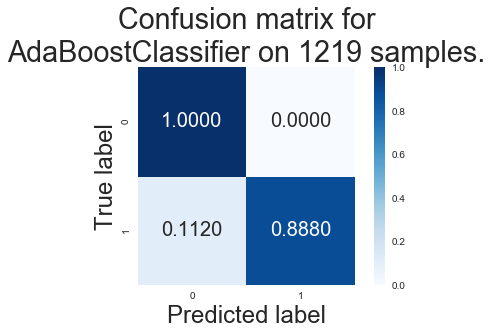

AdaBoostClassifier trained on 1219 samples.


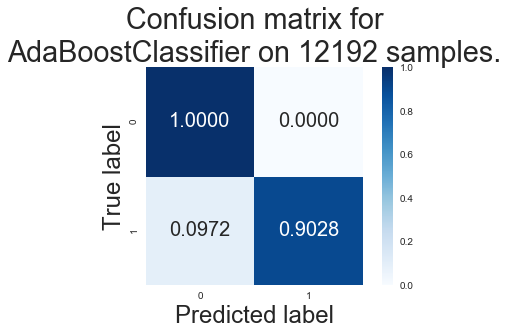

AdaBoostClassifier trained on 12192 samples.


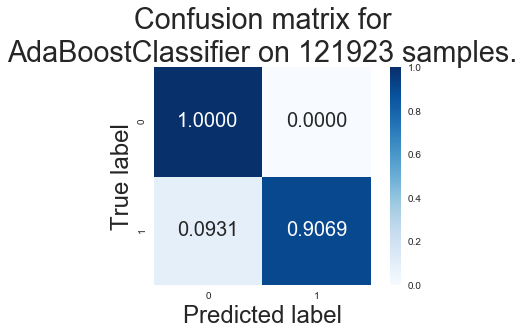

AdaBoostClassifier trained on 121923 samples.


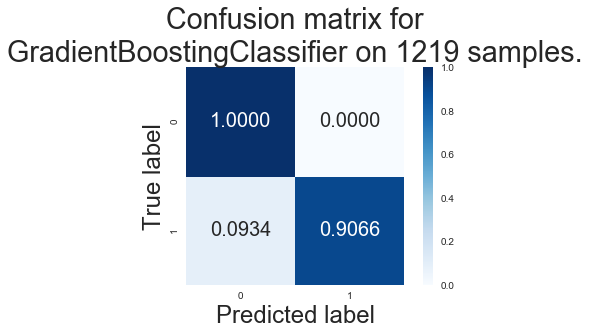

GradientBoostingClassifier trained on 1219 samples.


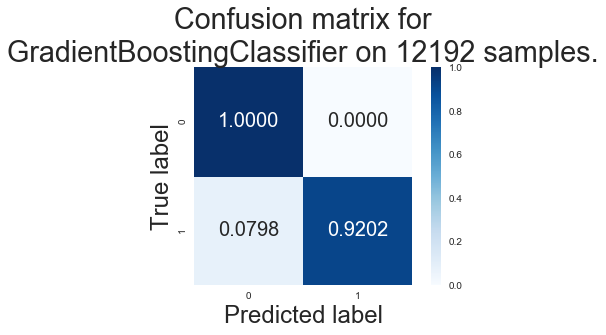

GradientBoostingClassifier trained on 12192 samples.


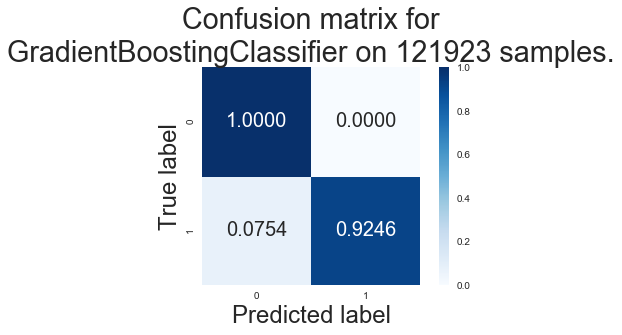

GradientBoostingClassifier trained on 121923 samples.


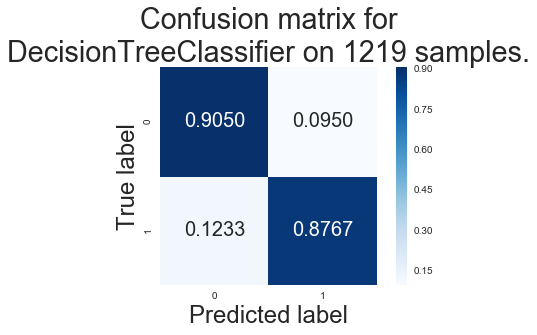

DecisionTreeClassifier trained on 1219 samples.


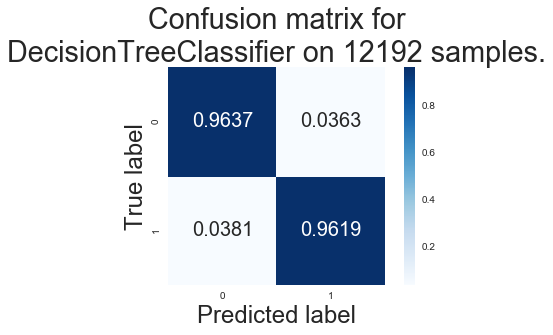

DecisionTreeClassifier trained on 12192 samples.


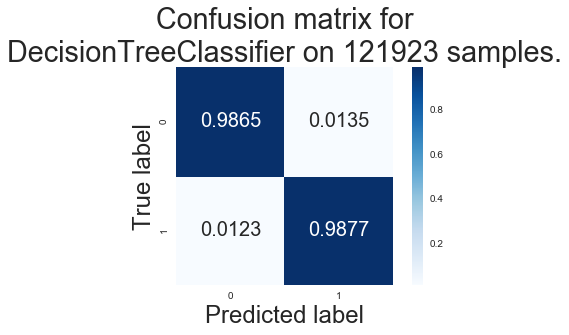

DecisionTreeClassifier trained on 121923 samples.


,1%,10%,100%
acc_test,0.943850,0.951281,0.953323
acc_train,0.943333,0.936667,0.940000
f_test,0.975385,0.978917,0.979872
f_train,0.976776,0.973757,0.975275
pred_time,0.251618,0.300720,0.231570
train_time,0.142626,0.498657,6.113801


,1%,10%,100%
acc_test,0.953200,0.959991,0.962206
acc_train,0.950000,0.950000,0.950000
f_test,0.979815,0.982944,0.983948
f_train,0.979730,0.979730,0.979730
pred_time,0.089798,0.074703,0.075983
train_time,0.150033,1.100689,17.455103


,1%,10%,100%
acc_test,0.890825,0.962821,0.987082
acc_train,1.000000,1.000000,1.000000
f_test,0.897332,0.963424,0.986785
f_train,1.000000,1.000000,1.000000
pred_time,0.010628,0.002534,0.008010
train_time,0.000000,0.051953,0.484522


In [90]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Initialize the three models
clf_A = AdaBoostClassifier()
clf_B = GradientBoostingClassifier()
clf_C = DecisionTreeClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
n_train = len(y_train)
print (n_train)
samples_1 = int(n_train * 0.01)
samples_10 = int(n_train * 0.1)
samples_100 = n_train

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

        
for i in results.items():
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

As seen Boosting and Decision Tree algorithms are working very good and the f_score on test set is around 98-99%. This score is pretty good as it is highly imbalanced data with class ratio 1:100.

# Applying gridsearch to find optimal hyperparameters for gradientBoosting

In [91]:
#define various range of params for sgd clf
tuned_parameters = [{'loss': [ 'deviance', 'exponential'],
                     'learning_rate':[0.1, 0.01],
                     'max_depth' : [2, 4, 6],
                      }]

#method 1 : using grid search to find best params for each data set
gbc_clf_a = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10)
gbc_clf_a.fit(input_train, label_train)
print("Best parameters set found on development set:")
print(gbc_clf_a.best_params_)
print(gbc_clf_a.best_score_)

Best parameters set found on development set:
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 6}
0.976017650484


In [92]:
#method 2: using above parameters train another model using partial fit and then test. Since partial fit cant be used with grid search cv
gbc_clf_b = GradientBoostingClassifier(learning_rate= 0.1, loss = 'deviance' ,max_depth= 6)
gbc_clf_b.fit(input_train,label_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [93]:
predicted_labels_b = gbc_clf_b.predict(input_test)
print ("Accuracy: {}".format(gbc_clf_b.score(input_test,label_test)))
print("f1_score: {}".format(f1_score(label_test, predicted_labels_b)))
print (confusion_matrix(label_test, predicted_labels_b))

Accuracy: 0.9771413104992496
f1_score: 0.9766706009392029
[[20266     8]
 [  921 19446]]


# Trying XGBoost algorithm

In [103]:
train = df_with_dummies
target = 'paid'

In [104]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['paid'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['paid'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['paid'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9894
AUC Score (Train): 0.604364


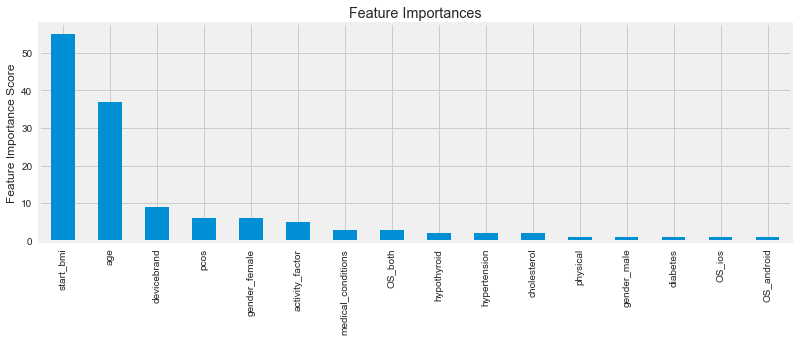

In [105]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In future, Tunning xgboost parameter can give higher AUC score.
As data is highly unbalance, Other way to optimize the model is to do Undersampling the majority target data.
Treating this problem as anamoly detection is also a way to go, but users having paid subscriptions are not having different trend than normal users as seen in above visualization. Clustering is also another way to try in later phase to cluster both groups.

# Dumping data as pickle file to reuse in Neural Networks model

In [124]:
preprocessed_data = [scaled_smote_features, smote_paid]
with open('preprocessed_smote_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)